In [1]:
import pandas as pd
from prophet import Prophet
from prophet.plot import plot_plotly, plot_components_plotly
import numpy as np
import itertools
import plotly.express as px
from prophet.plot import add_changepoints_to_plot
import seaborn as sns
from prophet.diagnostics import cross_validation,performance_metrics
from scipy.stats import f_oneway,kruskal,alexandergovern
from prophet.serialize import model_to_json, model_from_json
from scipy.stats import ttest_1samp
import matplotlib.pyplot as plt
from datetime import datetime

from matplotlib.dates import (
    MonthLocator,
    num2date,
    AutoDateLocator,
    AutoDateFormatter,
)

In [2]:
import plotly.io as pio
pio.renderers.default='notebook'

In [3]:
def combine_forecast_actual(model,forecast,period_dict):
    comb = forecast[["ds","yhat","yhat_lower","yhat_upper"]].merge(model.history[["ds","y"]], on ='ds',how="left")
    comb["diff"] = comb["yhat"]-comb["y"]
    comb["diff_upper"] = (comb["yhat_upper"]-comb["y"])
    comb["diff_lower"] = (comb["yhat_lower"]-comb["y"])
    comb["diff_percent"] = comb["diff"]/comb["yhat"]
    comb["diff_upper_percent"] = (comb["yhat_upper"]-comb["y"])/comb["yhat_upper"]
    comb["diff_lower_percent"] = (comb["yhat_lower"]-comb["y"])/comb["yhat_lower"]
    
    comb["period"] = np.where((comb['ds']<period_dict['t1_start'])& (comb['ds']>=period_dict['t0_start']), 't0',
                   np.where((comb['ds']<period_dict['t2_start']) & (comb['ds']>=period_dict['t1_start']), 't1',
                    np.where((comb['ds']<period_dict['t3_start']) & (comb['ds']>=period_dict['t2_start']), 't2',
                   "t3")))
    return comb

In [4]:
def compute_metric(df,result_name,best_params,main_period="t1"):
    metric_dict = {}
    metric_dict["name"] = result_name
    
    ## compute metric based on % change
    period_df = df.query("period == @main_period")
    actual_mean = np.mean(period_df["y"])
    for k in ["yhat","yhat_upper","yhat_lower"]:
        mean_diff = (np.mean(period_df[k]) -  actual_mean)/np.mean(period_df[k])*100
        metric_dict[k] = [mean_diff]
        
        
    ## compute metric based on errors between periods
    temp = [col for col_name, col in df.groupby("period")["diff"]]
    
    f_test = f_oneway(*temp)
    metric_dict["f_test"] = [f_test.statistic]
    metric_dict["f_test_p"] = [f_test.pvalue]
    
    kruskal_test = kruskal(*temp)
    metric_dict["kruskal_test"] = [kruskal_test.statistic]
    metric_dict["kruskal_test_p"] = [kruskal_test.pvalue]
    
    alexandergovern_test = alexandergovern(*temp)
    metric_dict["alexandergovern_test"] = [alexandergovern_test.statistic]
    metric_dict["alexandergovern_test_p"] = [alexandergovern_test.pvalue]
    
    for p in np.sort(df["period"].unique()):
        period_df = df.query("period == @p")["diff_percent"]
        metric_dict[p+"_error_percent_mean"] = np.mean(period_df)
        metric_dict[p+"_error_percent_std"] = np.std(period_df)
        t_test = ttest_1samp(period_df,0,alternative = "greater")
        metric_dict[p+"_ttest"] = t_test.statistic
        metric_dict[p+"_ttest_p"] = t_test.pvalue
    
 
    metric_dict = metric_dict | best_params
    
    return pd.DataFrame.from_dict(metric_dict)
    #return metric_dict

In [5]:
def train_model(data,
                label,
                period_dict,
                end_date = '2023-02-28',
                start_date = '2018-03-18',
                param_grid = None,
                mode="daily",
                best_params = None):
    
    if mode == "daily":
        daily_df = data.groupby('ds').size().to_frame("y").reset_index()
        daily_df.rename({"year_month_of_admission":"ds","count": "y"})
    elif mode == "weekly":
        daily_df = data.resample('W-MON', on='year_month_of_admission')["stay_number"].count().reset_index()
        daily_df.columns=["ds","y"]
        if param_grid is not None:
            param_grid["daily_seasonality"] = [False]
        if best_params is not None:
            best_params["daily_seasonality"] = False
    else:
        raise Exception("invalid mode")


    training_df = daily_df[(daily_df["ds"] <= end_date) & (daily_df["ds"] >= start_date) ]
    
    if best_params is None:
        all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
        rmses = []  # Store the RMSEs for each params here

        # Use cross validation to evaluate all parameters
        for params in all_params:
            m = Prophet(**params).fit(training_df)  # Fit model with given params
            df_cv = cross_validation(m, horizon='90 days', parallel="processes")
            df_p = performance_metrics(df_cv, rolling_window=1)
            rmses.append(df_p['rmse'].values[0])

        # Find the best parameters
        tuning_results = pd.DataFrame(all_params)
        tuning_results['rmse'] = rmses


        best_params = all_params[np.argmin(rmses)]
    
    m = Prophet(**best_params)
    m.fit(training_df)
    #model_list[diag] = m
    
    forecast = m.predict()
    
    combined_df = combine_forecast_actual(m,forecast,period_dict)
    temp_result = compute_metric(combined_df,label,best_params)
    #results_df = pd.concat([results_df,temp_result],ignore_index=True)
    
    return temp_result,m

In [15]:
def plot_graph(model,ax = None,fig=None,legend=True):
    forecast = model.predict()
    
    if ax is None:
        fig = plt.figure(facecolor='w',figsize=(10,6))
        ax = fig.add_subplot(111)

    #fig = m.plot(forecast,ax=ax, include_legend=True)

    fcst_t = forecast['ds'].dt.to_pydatetime()
    ax.plot(fcst_t, m.history['y'],color="black",
                label='Hosptal Admissions',ls = "solid")
    ax.plot(fcst_t, forecast['yhat'], ls='-', c='#0072B2', label='Predicted Hospital Admissions')

    ax.fill_between(fcst_t, forecast['yhat_lower'], forecast['yhat_upper'],
                    color='#0072B2', alpha=0.2, label='95% CI for Prediction')
    # Specify formatting to workaround matplotlib issue #12925
    locator = AutoDateLocator(interval_multiples=False)
    formatter = AutoDateFormatter(locator)
    ax.xaxis.set_major_locator(locator)
    ax.xaxis.set_major_formatter(formatter)

    #ax.set_xlabel("Time")
    ax.set_ylabel("Number of Hospital Admissions")
    ax.set_xlim(
        [
            pd.to_datetime(period_dict["t0_start"]).to_pydatetime(),
            pd.to_datetime(period_dict["t3_end"]).to_pydatetime()
        ])
    ax.axvline(x = pd.to_datetime(period_dict["t1_start"]).to_pydatetime(), 
               color = 'r', 
               label = 'COVID Lockdown',
              linestyle = '--')
    ax.axvline(x = pd.to_datetime(period_dict["t2_start"]).to_pydatetime(), 
               color = 'g', 
               label = 'Easing of Restrictions',
              linestyle = '-.')
    ax.axvline(x = pd.to_datetime(period_dict["t3_start"]).to_pydatetime(), 
               color = 'orange', 
               label = 'No Restrictions',
              linestyle = 'dotted')
    ax.spines[['right', 'top']].set_visible(False)
    if legend:
        ax.legend()
    ax.grid(alpha = 0.2, linestyle='-',axis='y')
    return fig,ax

### Analysis parameters

In [6]:
# dates to compute metrics
period_dict = {
    't0_start': '2018-03-01',
    't0_end' : '2020-03-17',
    't1_start' : '2020-03-18',
    't1_end' : '2020-06-30',
    't2_start' : '2020-07-1',
    't2_end' : '2021-10-11',  # 2020 july has significant effect
    't3_start' : '2021-10-12',
    't3_end' : '2023-02-28'
}

In [7]:
# dates to train the model
end_date = '2023-02-28'
start_date = '2016-03-01'

In [8]:
diagnosis_list = ['Cardiomyopathy and heart failure', 'Ischaemic Heart Disease',
       'Atrial fibrillation and flutter', 'Acute & Subacute endocarditis',
       'Cardiac arrest', 'Pulmonary embolism ',
       'Arrhythmias and conduction disorders', 'Myo-Peri-carditis']

# Data cleaning

In [22]:
df = pd.read_csv('cardiac_cohort_20230814.csv')
#df = df.query("facility_identifier == 'B210' or facility_identifier == 'B218' or facility_identifier == 'B224'")

C:\Users\Harrison Nguyen\AppData\Local\Temp\ipykernel_22208\951217380.py:1: DtypeWarning:

Columns (37) have mixed types. Specify dtype option on import or set low_memory=False.



In [29]:
df["facility_identifier"].unique()

array(['B210', 'B218', 'B212', 'B214', 'B224', 'B221', 'B226', 'B208',
       'B209', 'B101', 'B753'], dtype=object)

In [10]:
df.shape

(92137, 39)

In [30]:
# merge myocarditis and pericarditis
other_diag_list = ['Myocarditis','Pericarditis']
df["PRIMARY_DIAGNOSIS"] = np.where(
    df["PRIMARY_DIAGNOSIS"].isin(other_diag_list),"Myo-Peri-carditis",df["PRIMARY_DIAGNOSIS"]
)
df["Myo-Peri-carditis"] = df["Myocarditis"] | df["Pericarditis"]

In [31]:
# create a representation of the month with strfmt
df['year_month_of_admission'] = pd.to_datetime(df['admissiondatetime'])
#df = df[df['year_month_of_admission'].dt.year >= 2013]
# create a representation of the month with strfmt
df['ds'] = df['year_month_of_admission'].map(lambda dt: dt.strftime('%Y-%m-%d'))


In [32]:
df.columns

Index(['stay_number', 'facility_identifier', 'birth_date', 'gender_desc',
       'admissiondatetime', 'dischargedatetime', 'stay_SpecialtyOnDischarge',
       'stay_DivisionOnDischarge', 'emergency_status',
       'readmitted_within_28_days', 'readmit_this_hosp_28_days',
       'length_of_stay_total', 'age', 'patient_postcode', 'presenting_problem',
       'ModeOfSeparationOnDischarge', 'episode_mode_of_separation_desc',
       'area_of_usual_residence_desc', 'lhd_of_usual_residence',
       'finclassondischarge', 'indigenous_status_desc', 'marital_status_desc',
       'PRIMARY_DIAGNOSIS', 'Ischaemic Heart Disease', 'Myocardial infarction',
       'Pulmonary embolism', 'Pericarditis', 'Myocarditis',
       'Pericarditis and myocarditis', 'Acute & Subacute endocarditis',
       'Cardiomyopathy and heart failure', 'Cardiomyopathy', 'Heart failure',
       'Arrhythmias and conduction disorders',
       'Atrial fibrillation and flutter', 'Cardiac arrest',
       'CARDIAC_ADDITIONAL', 'COVI

# Demographics

In [26]:
df["period"] = np.where((df['ds']<period_dict['t1_start'])& (df['ds']>=period_dict['t0_start']), 't0',
                   np.where((df['ds']<period_dict['t2_start']) & (df['ds']>=period_dict['t1_start']), 't1',
                    np.where((df['ds']<period_dict['t3_start']) & (df['ds']>=period_dict['t2_start']), 't2',
                   "t3")))

In [40]:
df.groupby("period").describe()["age"].reset_index().to_csv("demographics/age_demographic.csv")

In [39]:
demographic_columns = ['gender_desc','area_of_usual_residence_desc',
                       'lhd_of_usual_residence',
                       'finclassondischarge',
                       'indigenous_status_desc', 
                       'marital_status_desc',
                     'death' ]
for d in demographic_columns:
    temp = df.groupby("period")[d].value_counts(normalize=True)
    print(temp)
    temp.to_csv("demographics/" + d+"_demographic.csv")

period  gender_desc  
t0      Male             0.567797
        Female           0.432203
t1      Male             0.586817
        Female           0.413183
t2      Male             0.580359
        Female           0.419641
t3      Male             0.551872
        Female           0.448104
        Indeterminate    0.000024
Name: proportion, dtype: float64
period  area_of_usual_residence_desc  
t0      Ryde (C)                          0.120835
        Warringah (A)                     0.120687
        Ku-ring-gai (A)                   0.090429
        Hornsby (A) - South               0.085838
        Willoughby (C)                    0.077793
                                            ...   
t3      Meander Valley (M) - Pt B         0.000012
        Melbourne (C) - Inner             0.000012
        Melbourne (C) - Remainder         0.000012
        Melbourne (C) - S'bank-D'lands    0.000012
        Murray (A)                        0.000012
Name: proportion, Length: 1007, dtype: 

# Model building

## Primary and Additional diagnosis

In [33]:
daily_df = df.groupby('ds').size().to_frame("y").reset_index()
daily_df.rename({"year_month_of_admission":"ds","count": "y"})

ds   y
0     2012-01-01  17
1     2012-01-02  23
2     2012-01-03  32
3     2012-01-04  29
4     2012-01-05  31
...          ...  ..
4188  2023-06-20   4
4189  2023-06-21   2
4190  2023-06-22   3
4191  2023-06-23   1
4192  2023-06-28   2

[4193 rows x 2 columns]

### build a model for entire data set 2012-2023

In [34]:
m = Prophet()
m.fit(daily_df)

19:52:24 - cmdstanpy - INFO - Chain [1] start processing
19:52:24 - cmdstanpy - INFO - Chain [1] done processing


In [35]:
forecast = m.predict()

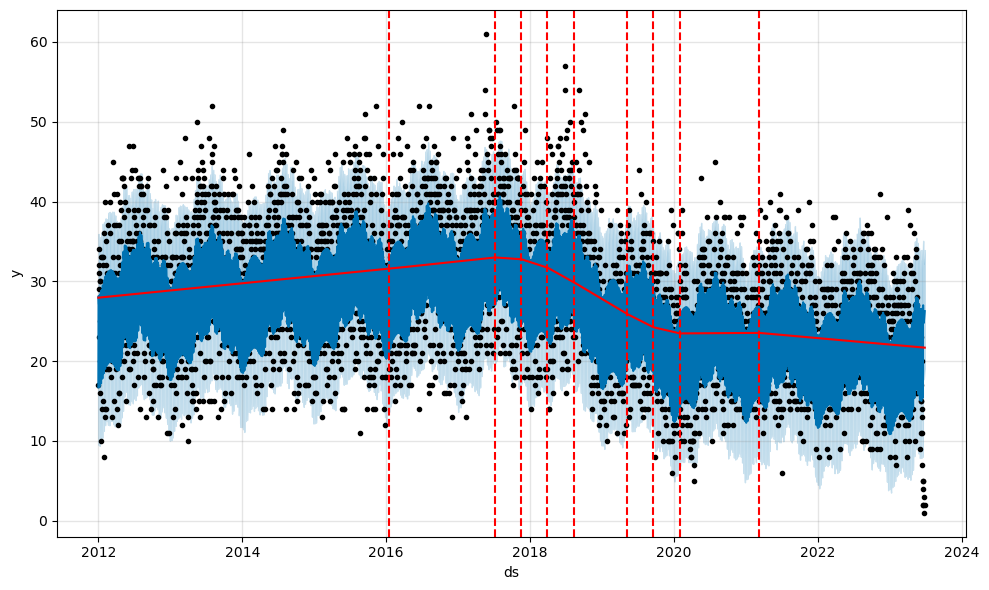

In [36]:
fig = m.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), m, forecast)

In [37]:
signif_changepoints = m.changepoints[
            np.abs(np.nanmean(m.params['delta'], axis=0)) >= 0.01
        ]
signif_changepoints

1475   2016-01-15
2012   2017-07-05
2146   2017-11-16
2280   2018-03-30
2414   2018-08-11
2682   2019-05-06
2817   2019-09-18
2951   2020-01-30
3353   2021-03-07
Name: ds, dtype: datetime64[ns]

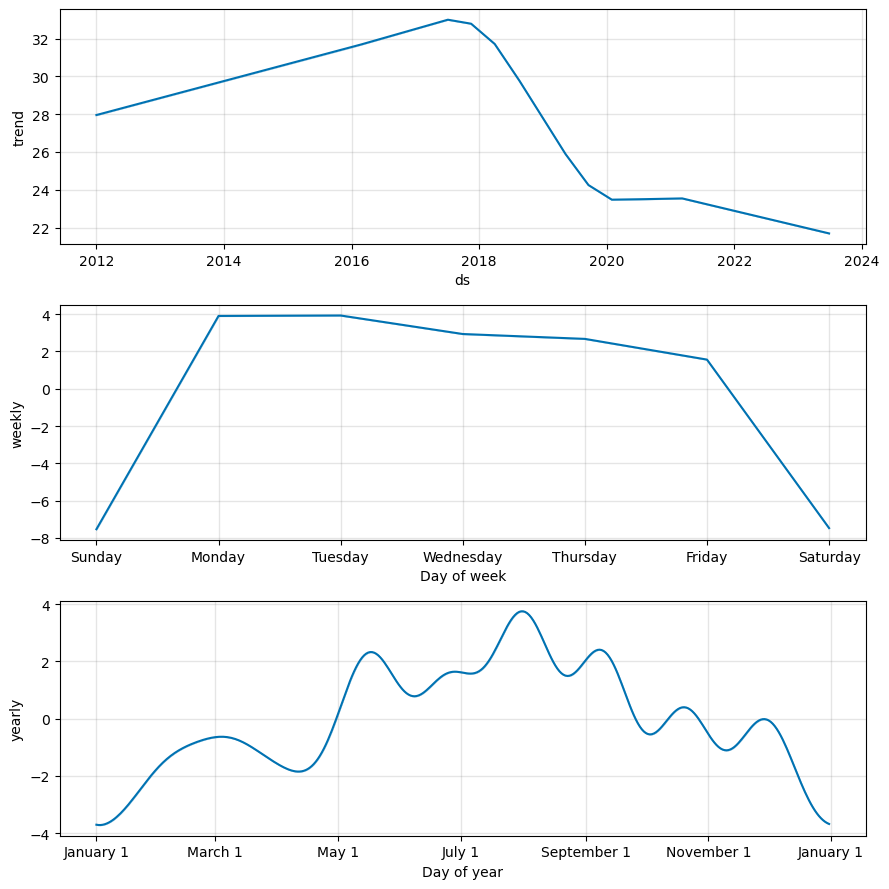

In [38]:
fig2 = m.plot_components(forecast)

### 2018-2023 model

In [129]:
end_date = '2023-02-28'
start_date = '2018-03-18'



In [131]:
#{'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.01}
param_grid = {  
    'changepoint_prior_scale': [0.01,0.02,0.04,0.1],
    'seasonality_prior_scale': [0.01,0.02,0.04,0.1],
    #'changepoint_prior_scale': [0.005],
    #'seasonality_prior_scale': [0.005],
    'n_changepoints': [0]
}

In [132]:
temp_result_daily, model = train_model(df,
                                 "primary_additional_daily",
                                 period_dict,
                                 end_date = end_date,
                                 start_date = start_date,
                                mode = "daily",
                                param_grid = param_grid)

with open('model/p_a_daily.json', 'w') as fout:
    fout.write(model_to_json(model)) 

18:50:37 - cmdstanpy - INFO - Chain [1] start processing
18:50:37 - cmdstanpy - INFO - Chain [1] done processing
18:50:47 - cmdstanpy - INFO - Chain [1] start processing
18:50:47 - cmdstanpy - INFO - Chain [1] done processing
18:50:47 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
18:50:47 - cmdstanpy - INFO - Chain [1] start processing
18:50:48 - cmdstanpy - INFO - Chain [1] done processing
18:50:55 - cmdstanpy - INFO - Chain [1] start processing
18:50:56 - cmdstanpy - INFO - Chain [1] done processing
18:50:56 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
18:50:56 - cmdstanpy - INFO - Chain [1] start processing
18:50:56 - cmdstanpy - INFO - Chain [1] done processing
18:51:06 - cmdstanpy - INFO - Chain [1] start processing
18:51:06 - cmdstanpy - INFO - Chain [1] done processing
18:51:06 -

In [133]:
forecast = model.predict()

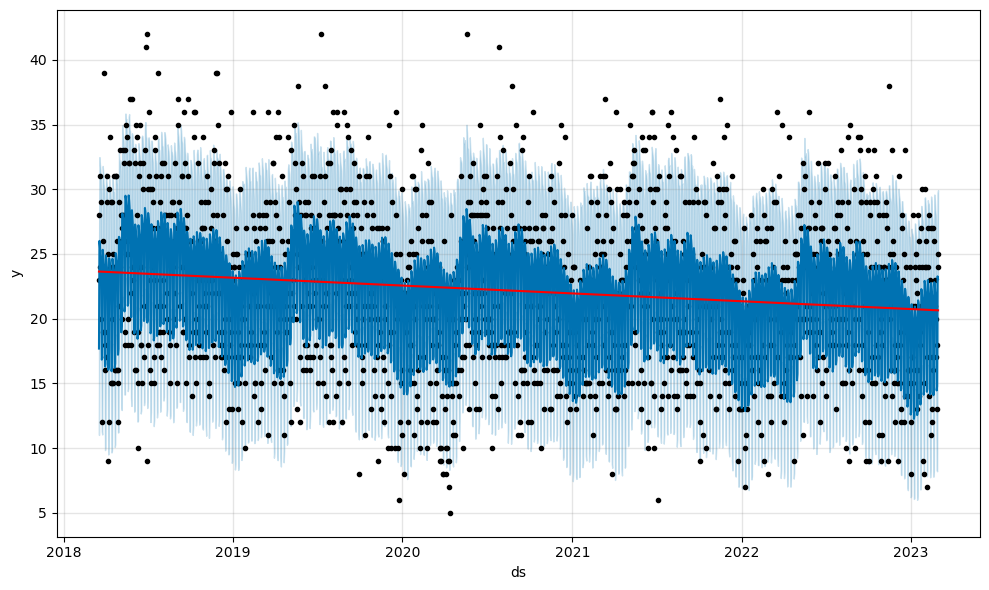

In [134]:
fig = model.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), model, forecast)

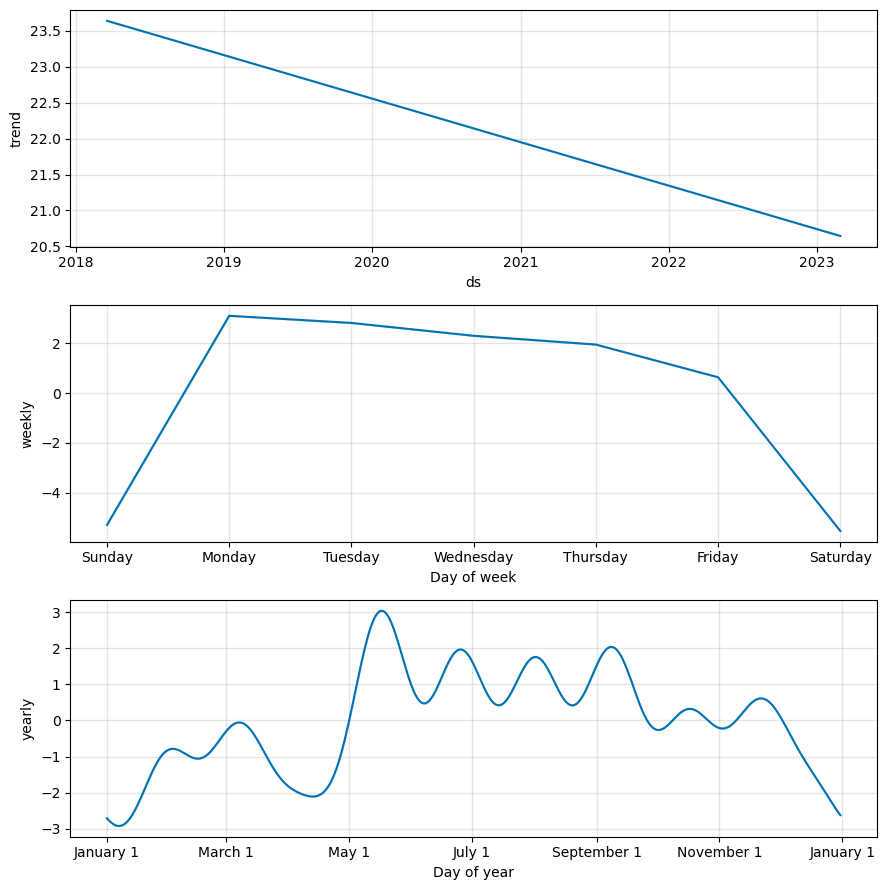

In [135]:
fig2 = model.plot_components(forecast)

In [136]:
signif_changepoints = m.changepoints[
            np.abs(np.nanmean(m.params['delta'], axis=0)) >= 0.01
        ]
signif_changepoints

type: Boolean index has wrong length: 1 instead of 0

In [137]:
temp_result_daily

yhat  yhat_upper  yhat_lower     f_test      f_test_p  kruskal_test  \
0  12.430767    31.42169  -21.575722  18.584663  1.024986e-08     30.770307   

   kruskal_test_p  alexandergovern_test  alexandergovern_test_p  \
0    2.081194e-07             28.131381            7.786607e-07   

                       name  changepoint_prior_scale  seasonality_prior_scale  \
0  primary_additional_daily                     0.04                     0.02   

   n_changepoints  
0               0

### By diagnosis

In [138]:
for diag in diagnosis_list:
    print("running model for ", diag)
    diag_df =  df.query("PRIMARY_DIAGNOSIS == @diag | @diag == 'True'")
    
    label = "p_a_daily_"+diag.replace(" ", "_")
    
    temp_result_p, model_p =  train_model(diag_df,
                                 label,
                                 period_dict,
                                param_grid = param_grid,
                                 end_date = end_date,
                                 start_date = start_date,
                                mode = "daily")
    temp_result_daily = pd.concat([temp_result_daily,temp_result_p],ignore_index=True)
    
    
    with open('model/' + label + '.json', 'w') as fout:
        fout.write(model_to_json(model)) 

running model for  Cardiomyopathy and heart failure


19:01:33 - cmdstanpy - INFO - Chain [1] start processing
19:01:33 - cmdstanpy - INFO - Chain [1] done processing
19:01:48 - cmdstanpy - INFO - Chain [1] start processing
19:01:48 - cmdstanpy - INFO - Chain [1] done processing
19:01:48 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
19:01:48 - cmdstanpy - INFO - Chain [1] start processing
19:01:49 - cmdstanpy - INFO - Chain [1] done processing
19:02:03 - cmdstanpy - INFO - Chain [1] start processing
19:02:03 - cmdstanpy - INFO - Chain [1] done processing
19:02:03 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
19:02:03 - cmdstanpy - INFO - Chain [1] start processing
19:02:04 - cmdstanpy - INFO - Chain [1] done processing
19:02:58 - cmdstanpy - INFO - Chain [1] start processing
19:02:59 - cmdstanpy - INFO - Chain [1] done processing
19:02:59 -

running model for  Ischaemic Heart Disease


19:08:14 - cmdstanpy - INFO - Chain [1] start processing
19:08:14 - cmdstanpy - INFO - Chain [1] done processing
19:08:14 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
19:08:14 - cmdstanpy - INFO - Chain [1] start processing
19:08:15 - cmdstanpy - INFO - Chain [1] done processing
19:08:23 - cmdstanpy - INFO - Chain [1] start processing
19:08:23 - cmdstanpy - INFO - Chain [1] done processing
19:08:23 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
19:08:23 - cmdstanpy - INFO - Chain [1] start processing
19:08:24 - cmdstanpy - INFO - Chain [1] done processing
19:08:39 - cmdstanpy - INFO - Chain [1] start processing
19:08:39 - cmdstanpy - INFO - Chain [1] done processing
19:08:39 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abn

running model for  Atrial fibrillation and flutter


19:13:55 - cmdstanpy - INFO - Chain [1] start processing
19:13:55 - cmdstanpy - INFO - Chain [1] done processing
19:13:55 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
19:13:55 - cmdstanpy - INFO - Chain [1] start processing
19:13:55 - cmdstanpy - INFO - Chain [1] done processing
19:14:04 - cmdstanpy - INFO - Chain [1] start processing
19:14:04 - cmdstanpy - INFO - Chain [1] done processing
19:14:04 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
19:14:04 - cmdstanpy - INFO - Chain [1] start processing
19:14:05 - cmdstanpy - INFO - Chain [1] done processing
19:14:20 - cmdstanpy - INFO - Chain [1] start processing
19:14:20 - cmdstanpy - INFO - Chain [1] done processing
19:14:20 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abn

running model for  Acute & Subacute endocarditis


19:22:28 - cmdstanpy - INFO - Chain [1] start processing
19:22:29 - cmdstanpy - INFO - Chain [1] done processing
19:22:34 - cmdstanpy - INFO - Chain [1] start processing
19:22:34 - cmdstanpy - INFO - Chain [1] done processing
19:22:34 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
19:22:34 - cmdstanpy - INFO - Chain [1] start processing
19:22:34 - cmdstanpy - INFO - Chain [1] done processing
19:22:43 - cmdstanpy - INFO - Chain [1] start processing
19:22:43 - cmdstanpy - INFO - Chain [1] done processing
19:22:43 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
19:22:43 - cmdstanpy - INFO - Chain [1] start processing
19:22:43 - cmdstanpy - INFO - Chain [1] done processing
19:22:49 - cmdstanpy - INFO - Chain [1] start processing
19:22:49 - cmdstanpy - INFO - Chain [1] done processing
19:22:49 -

running model for  Cardiac arrest


19:24:08 - cmdstanpy - INFO - Chain [1] start processing
19:24:08 - cmdstanpy - INFO - Chain [1] done processing
19:24:08 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
19:24:08 - cmdstanpy - INFO - Chain [1] start processing
19:24:08 - cmdstanpy - INFO - Chain [1] done processing
19:24:13 - cmdstanpy - INFO - Chain [1] start processing
19:24:13 - cmdstanpy - INFO - Chain [1] done processing
19:24:13 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
19:24:13 - cmdstanpy - INFO - Chain [1] start processing
19:24:13 - cmdstanpy - INFO - Chain [1] done processing
19:24:19 - cmdstanpy - INFO - Chain [1] start processing
19:24:19 - cmdstanpy - INFO - Chain [1] done processing
19:24:19 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abn

running model for  Pulmonary embolism 


19:26:11 - cmdstanpy - INFO - Chain [1] start processing
19:26:11 - cmdstanpy - INFO - Chain [1] done processing
19:26:11 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
19:26:11 - cmdstanpy - INFO - Chain [1] start processing
19:26:12 - cmdstanpy - INFO - Chain [1] done processing
19:26:24 - cmdstanpy - INFO - Chain [1] start processing
19:26:24 - cmdstanpy - INFO - Chain [1] done processing
19:26:24 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
19:26:24 - cmdstanpy - INFO - Chain [1] start processing
19:26:25 - cmdstanpy - INFO - Chain [1] done processing
19:26:32 - cmdstanpy - INFO - Chain [1] start processing
19:26:32 - cmdstanpy - INFO - Chain [1] done processing
19:26:32 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abn

running model for  Arrhythmias and conduction disorders


19:31:47 - cmdstanpy - INFO - Chain [1] start processing
19:31:47 - cmdstanpy - INFO - Chain [1] done processing
19:31:47 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
19:31:47 - cmdstanpy - INFO - Chain [1] start processing
19:31:47 - cmdstanpy - INFO - Chain [1] done processing
19:32:02 - cmdstanpy - INFO - Chain [1] start processing
19:32:02 - cmdstanpy - INFO - Chain [1] done processing
19:32:02 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
19:32:02 - cmdstanpy - INFO - Chain [1] start processing
19:32:03 - cmdstanpy - INFO - Chain [1] done processing
19:32:22 - cmdstanpy - INFO - Chain [1] start processing
19:32:22 - cmdstanpy - INFO - Chain [1] done processing
19:32:29 - cmdstanpy - INFO - Chain [1] start processing
19:32:30 - cmdstanpy - INFO - Chain [1] done processing
19:32:30 -

running model for  Myo-Peri-carditis


19:35:10 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
19:35:10 - cmdstanpy - INFO - Chain [1] start processing
19:35:11 - cmdstanpy - INFO - Chain [1] done processing
19:35:50 - cmdstanpy - INFO - Chain [1] start processing
19:35:50 - cmdstanpy - INFO - Chain [1] done processing
19:35:50 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
19:35:50 - cmdstanpy - INFO - Chain [1] start processing
19:35:50 - cmdstanpy - INFO - Chain [1] done processing
19:35:56 - cmdstanpy - INFO - Chain [1] start processing
19:35:56 - cmdstanpy - INFO - Chain [1] done processing
19:35:56 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
19:35:56 - cmdstanpy - INFO - Chain [1] start processing
19:35:56 - cmdstanpy - 

KeyboardInterrupt: 

In [ ]:
temp_result_daily.to_csv("primary_additional_results.csv",index=False)

## Primary only diagnosis

In [124]:
primary_model_list = {}
primary_result_df = pd.DataFrame(columns = ["name","yhat","yhat_upper","yhat_lower",'changepoint_prior_scale','seasonality_prior_scale'])


In [132]:
diag_df =  df.query("PRIMARY_DIAGNOSIS == PRIMARY_DIAGNOSIS")
    
temp_result, model = train_model(diag_df,"primary",param_grid,period_dict,end_date = end_date,start_date = start_date)
    
primary_result_df = pd.concat([primary_result_df,temp_result],ignore_index=True)
primary_model_list["primary"] = model

13:34:29 - cmdstanpy - INFO - Chain [1] start processing
13:34:30 - cmdstanpy - INFO - Chain [1] done processing
13:34:35 - cmdstanpy - INFO - Chain [1] start processing
13:34:35 - cmdstanpy - INFO - Chain [1] done processing
13:34:41 - cmdstanpy - INFO - Chain [1] start processing
13:34:41 - cmdstanpy - INFO - Chain [1] done processing
13:34:47 - cmdstanpy - INFO - Chain [1] start processing
13:34:47 - cmdstanpy - INFO - Chain [1] done processing
13:34:53 - cmdstanpy - INFO - Chain [1] start processing
13:34:53 - cmdstanpy - INFO - Chain [1] done processing
13:34:59 - cmdstanpy - INFO - Chain [1] start processing
13:34:59 - cmdstanpy - INFO - Chain [1] done processing
13:35:04 - cmdstanpy - INFO - Chain [1] start processing
13:35:05 - cmdstanpy - INFO - Chain [1] done processing
13:35:10 - cmdstanpy - INFO - Chain [1] start processing
13:35:10 - cmdstanpy - INFO - Chain [1] done processing
13:35:16 - cmdstanpy - INFO - Chain [1] start processing
13:35:16 - cmdstanpy - INFO - Chain [1]

In [136]:
primary_model_list["primary"] = model

In [137]:
for diag in diagnosis_list:
    print("running model for ", diag)
    diag_df =  df.query("PRIMARY_DIAGNOSIS == @diag")
    
    temp_result, model = train_model(diag_df,diag,param_grid,period_dict,end_date = end_date,start_date = start_date)
    
    primary_result_df = pd.concat([primary_result_df,temp_result],ignore_index=True)
    primary_model_list[diag] = model

running model for  Cardiomyopathy and heart failure


13:38:53 - cmdstanpy - INFO - Chain [1] start processing
13:38:53 - cmdstanpy - INFO - Chain [1] done processing
13:39:00 - cmdstanpy - INFO - Chain [1] start processing
13:39:00 - cmdstanpy - INFO - Chain [1] done processing
13:39:06 - cmdstanpy - INFO - Chain [1] start processing
13:39:06 - cmdstanpy - INFO - Chain [1] done processing
13:39:12 - cmdstanpy - INFO - Chain [1] start processing
13:39:13 - cmdstanpy - INFO - Chain [1] done processing
13:39:19 - cmdstanpy - INFO - Chain [1] start processing
13:39:19 - cmdstanpy - INFO - Chain [1] done processing
13:39:25 - cmdstanpy - INFO - Chain [1] start processing
13:39:26 - cmdstanpy - INFO - Chain [1] done processing
13:39:32 - cmdstanpy - INFO - Chain [1] start processing
13:39:32 - cmdstanpy - INFO - Chain [1] done processing
13:39:38 - cmdstanpy - INFO - Chain [1] start processing
13:39:38 - cmdstanpy - INFO - Chain [1] done processing
13:39:45 - cmdstanpy - INFO - Chain [1] start processing
13:39:45 - cmdstanpy - INFO - Chain [1]

running model for  Ischaemic Heart Disease


13:40:38 - cmdstanpy - INFO - Chain [1] start processing
13:40:38 - cmdstanpy - INFO - Chain [1] done processing
13:40:44 - cmdstanpy - INFO - Chain [1] start processing
13:40:44 - cmdstanpy - INFO - Chain [1] done processing
13:40:50 - cmdstanpy - INFO - Chain [1] start processing
13:40:50 - cmdstanpy - INFO - Chain [1] done processing
13:40:57 - cmdstanpy - INFO - Chain [1] start processing
13:40:57 - cmdstanpy - INFO - Chain [1] done processing
13:41:03 - cmdstanpy - INFO - Chain [1] start processing
13:41:03 - cmdstanpy - INFO - Chain [1] done processing
13:41:10 - cmdstanpy - INFO - Chain [1] start processing
13:41:10 - cmdstanpy - INFO - Chain [1] done processing
13:41:16 - cmdstanpy - INFO - Chain [1] start processing
13:41:16 - cmdstanpy - INFO - Chain [1] done processing
13:41:22 - cmdstanpy - INFO - Chain [1] start processing
13:41:23 - cmdstanpy - INFO - Chain [1] done processing
13:41:29 - cmdstanpy - INFO - Chain [1] start processing
13:41:29 - cmdstanpy - INFO - Chain [1]

running model for  Atrial fibrillation and flutter


13:42:22 - cmdstanpy - INFO - Chain [1] start processing
13:42:22 - cmdstanpy - INFO - Chain [1] done processing
13:42:28 - cmdstanpy - INFO - Chain [1] start processing
13:42:29 - cmdstanpy - INFO - Chain [1] done processing
13:42:35 - cmdstanpy - INFO - Chain [1] start processing
13:42:35 - cmdstanpy - INFO - Chain [1] done processing
13:42:41 - cmdstanpy - INFO - Chain [1] start processing
13:42:41 - cmdstanpy - INFO - Chain [1] done processing
13:42:48 - cmdstanpy - INFO - Chain [1] start processing
13:42:48 - cmdstanpy - INFO - Chain [1] done processing
13:42:54 - cmdstanpy - INFO - Chain [1] start processing
13:42:54 - cmdstanpy - INFO - Chain [1] done processing
13:43:01 - cmdstanpy - INFO - Chain [1] start processing
13:43:01 - cmdstanpy - INFO - Chain [1] done processing
13:43:07 - cmdstanpy - INFO - Chain [1] start processing
13:43:08 - cmdstanpy - INFO - Chain [1] done processing
13:43:14 - cmdstanpy - INFO - Chain [1] start processing
13:43:14 - cmdstanpy - INFO - Chain [1]

running model for  Acute & Subacute endocarditis


13:44:12 - cmdstanpy - INFO - Chain [1] start processing
13:44:13 - cmdstanpy - INFO - Chain [1] done processing
13:44:18 - cmdstanpy - INFO - Chain [1] start processing
13:44:18 - cmdstanpy - INFO - Chain [1] done processing
13:44:24 - cmdstanpy - INFO - Chain [1] start processing
13:44:24 - cmdstanpy - INFO - Chain [1] done processing
13:44:31 - cmdstanpy - INFO - Chain [1] start processing
13:44:31 - cmdstanpy - INFO - Chain [1] done processing
13:44:37 - cmdstanpy - INFO - Chain [1] start processing
13:44:37 - cmdstanpy - INFO - Chain [1] done processing
13:44:43 - cmdstanpy - INFO - Chain [1] start processing
13:44:44 - cmdstanpy - INFO - Chain [1] done processing
13:44:49 - cmdstanpy - INFO - Chain [1] start processing
13:44:49 - cmdstanpy - INFO - Chain [1] done processing
13:44:55 - cmdstanpy - INFO - Chain [1] start processing
13:44:56 - cmdstanpy - INFO - Chain [1] done processing
13:45:01 - cmdstanpy - INFO - Chain [1] start processing
13:45:01 - cmdstanpy - INFO - Chain [1]

running model for  Cardiac arrest


13:45:41 - cmdstanpy - INFO - Chain [1] start processing
13:45:41 - cmdstanpy - INFO - Chain [1] done processing
13:45:46 - cmdstanpy - INFO - Chain [1] start processing
13:45:46 - cmdstanpy - INFO - Chain [1] done processing
13:45:52 - cmdstanpy - INFO - Chain [1] start processing
13:45:52 - cmdstanpy - INFO - Chain [1] done processing
13:45:58 - cmdstanpy - INFO - Chain [1] start processing
13:45:58 - cmdstanpy - INFO - Chain [1] done processing
13:46:04 - cmdstanpy - INFO - Chain [1] start processing
13:46:04 - cmdstanpy - INFO - Chain [1] done processing
13:46:10 - cmdstanpy - INFO - Chain [1] start processing
13:46:10 - cmdstanpy - INFO - Chain [1] done processing
13:46:16 - cmdstanpy - INFO - Chain [1] start processing
13:46:16 - cmdstanpy - INFO - Chain [1] done processing
13:46:22 - cmdstanpy - INFO - Chain [1] start processing
13:46:22 - cmdstanpy - INFO - Chain [1] done processing
13:46:28 - cmdstanpy - INFO - Chain [1] start processing
13:46:28 - cmdstanpy - INFO - Chain [1]

running model for  Pulmonary embolism 


13:47:49 - cmdstanpy - INFO - Chain [1] start processing
13:47:49 - cmdstanpy - INFO - Chain [1] done processing
13:47:55 - cmdstanpy - INFO - Chain [1] start processing
13:47:55 - cmdstanpy - INFO - Chain [1] done processing
13:48:00 - cmdstanpy - INFO - Chain [1] start processing
13:48:00 - cmdstanpy - INFO - Chain [1] done processing
13:48:06 - cmdstanpy - INFO - Chain [1] start processing
13:48:06 - cmdstanpy - INFO - Chain [1] done processing
13:48:11 - cmdstanpy - INFO - Chain [1] start processing
13:48:11 - cmdstanpy - INFO - Chain [1] done processing
13:48:17 - cmdstanpy - INFO - Chain [1] start processing
13:48:17 - cmdstanpy - INFO - Chain [1] done processing
13:48:22 - cmdstanpy - INFO - Chain [1] start processing
13:48:22 - cmdstanpy - INFO - Chain [1] done processing
13:48:28 - cmdstanpy - INFO - Chain [1] start processing
13:48:28 - cmdstanpy - INFO - Chain [1] done processing
13:48:33 - cmdstanpy - INFO - Chain [1] start processing
13:48:33 - cmdstanpy - INFO - Chain [1]

running model for  Arrhythmias and conduction disorders


13:49:18 - cmdstanpy - INFO - Chain [1] done processing
13:49:24 - cmdstanpy - INFO - Chain [1] start processing
13:49:24 - cmdstanpy - INFO - Chain [1] done processing
13:49:30 - cmdstanpy - INFO - Chain [1] start processing
13:49:30 - cmdstanpy - INFO - Chain [1] done processing
13:49:35 - cmdstanpy - INFO - Chain [1] start processing
13:49:35 - cmdstanpy - INFO - Chain [1] done processing
13:49:41 - cmdstanpy - INFO - Chain [1] start processing
13:49:41 - cmdstanpy - INFO - Chain [1] done processing
13:49:47 - cmdstanpy - INFO - Chain [1] start processing
13:49:47 - cmdstanpy - INFO - Chain [1] done processing
13:49:53 - cmdstanpy - INFO - Chain [1] start processing
13:49:53 - cmdstanpy - INFO - Chain [1] done processing
13:49:58 - cmdstanpy - INFO - Chain [1] start processing
13:49:58 - cmdstanpy - INFO - Chain [1] done processing
13:50:04 - cmdstanpy - INFO - Chain [1] start processing
13:50:04 - cmdstanpy - INFO - Chain [1] done processing
13:50:10 - cmdstanpy - INFO - Chain [1] 

running model for  Pericarditis


13:50:55 - cmdstanpy - INFO - Chain [1] start processing
13:50:55 - cmdstanpy - INFO - Chain [1] done processing
13:51:01 - cmdstanpy - INFO - Chain [1] start processing
13:51:01 - cmdstanpy - INFO - Chain [1] done processing
13:51:06 - cmdstanpy - INFO - Chain [1] start processing
13:51:06 - cmdstanpy - INFO - Chain [1] done processing
13:51:12 - cmdstanpy - INFO - Chain [1] start processing
13:51:12 - cmdstanpy - INFO - Chain [1] done processing
13:51:17 - cmdstanpy - INFO - Chain [1] start processing
13:51:17 - cmdstanpy - INFO - Chain [1] done processing
13:51:22 - cmdstanpy - INFO - Chain [1] start processing
13:51:22 - cmdstanpy - INFO - Chain [1] done processing
13:51:28 - cmdstanpy - INFO - Chain [1] start processing
13:51:28 - cmdstanpy - INFO - Chain [1] done processing
13:51:33 - cmdstanpy - INFO - Chain [1] start processing
13:51:33 - cmdstanpy - INFO - Chain [1] done processing
13:51:39 - cmdstanpy - INFO - Chain [1] start processing
13:51:39 - cmdstanpy - INFO - Chain [1]

running model for  Myocarditis


In [139]:
primary_result_df.to_csv("primary_results.csv",index=False)

type: name 'primary_result_df' is not defined

# Weekly Forecast

## primary and additional

In [77]:
params = {'changepoint_prior_scale': 0.01,
 'seasonality_prior_scale': 0.02,
 'n_changepoints': 0}
    
temp_result, model = train_model(df,
                                 "primary_additional_weekly",
                                 period_dict,
                                 end_date = end_date,
                                 start_date = start_date,
                                mode = "weekly",
                                best_params = params)

with open('model/p_a_weekly.json', 'w') as fout:
    fout.write(model_to_json(model)) 

10:26:17 - cmdstanpy - INFO - Chain [1] start processing
10:26:17 - cmdstanpy - INFO - Chain [1] done processing
10:26:17 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
10:26:17 - cmdstanpy - INFO - Chain [1] start processing
10:26:17 - cmdstanpy - INFO - Chain [1] done processing


In [15]:
with open('model/p_a_weekly.json', 'r') as fin:
    m = model_from_json(fin.read())  # Load model

In [79]:
temp_result

name       yhat  yhat_upper  yhat_lower     f_test  \
0  primary_additional_weekly  12.313577   21.785009    0.218072  11.044036   

       f_test_p  kruskal_test  kruskal_test_p  alexandergovern_test  \
0  5.930561e-07     15.203342        0.001651             12.241786   

   alexandergovern_test_p  ...  t2_ttest  t2_ttest_p  t3_error_percent_mean  \
0                0.006599  ...  0.567101    0.286285              -0.001277   

   t3_error_percent_std  t3_ttest  t3_ttest_p  changepoint_prior_scale  \
0              0.084827 -0.199127    0.578803                     0.01   

   seasonality_prior_scale  n_changepoints  daily_seasonality  
0                     0.02               0              False  

[1 rows x 30 columns]

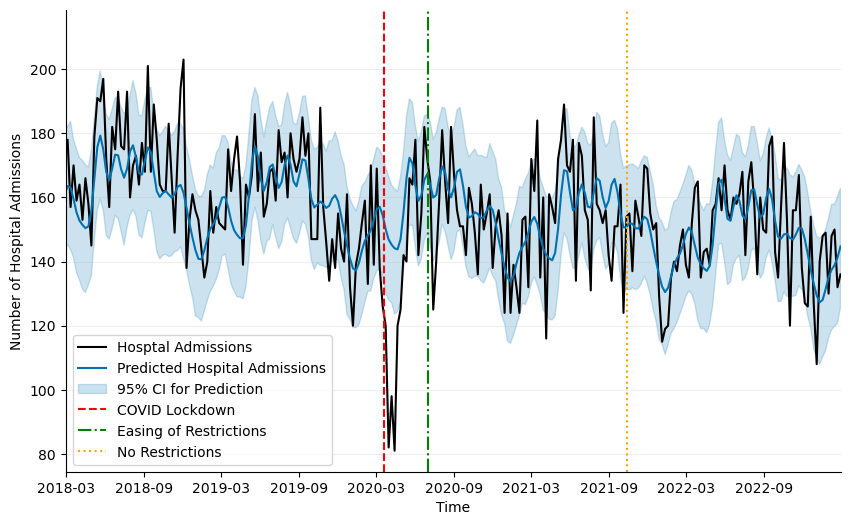

In [101]:
fig,ax = plot_graph(m)
plt.savefig("figures/p_a_weekly.png",bbox_inches = "tight")

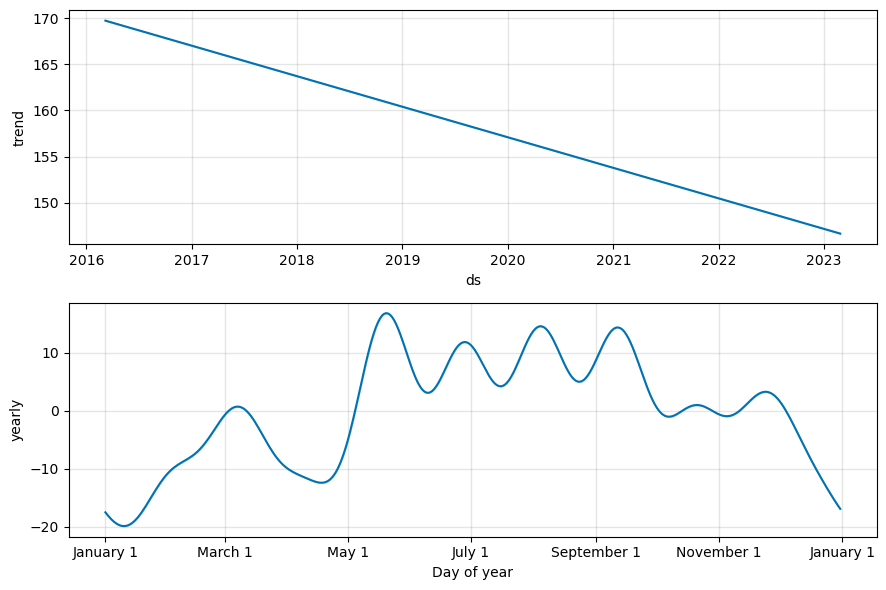

In [17]:
fig2 = m.plot_components(forecast)

### Specific diagnosis

In [84]:
param_grid = {  
    'changepoint_prior_scale': [0.005,0.01,0.02,0.04],
    'seasonality_prior_scale': [0.005,0.01,0.02,0.04],
    #'changepoint_prior_scale': [0.005],
    #'seasonality_prior_scale': [0.005],
    'n_changepoints': [0]
}

In [85]:
for diag in diagnosis_list:
    print("running model for ", diag)
    diag_df =  df.query("PRIMARY_DIAGNOSIS == @diag | @diag == 'True'")
    
    label = "p_a_weekly_"+diag.replace(" ", "_")
    
    temp_result_p, model_p =  train_model(diag_df,
                                 label,
                                 period_dict,
                                param_grid = param_grid,
                                 end_date = end_date,
                                 start_date = start_date,
                                mode = "weekly")
    temp_result = pd.concat([temp_result,temp_result_p],ignore_index=True)
    
    
    with open('model/' + label + '.json', 'w') as fout:
        fout.write(model_to_json(model_p)) 

10:26:48 - cmdstanpy - INFO - Chain [1] start processing
10:26:48 - cmdstanpy - INFO - Chain [1] done processing


running model for  Cardiomyopathy and heart failure


10:26:48 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
10:26:48 - cmdstanpy - INFO - Chain [1] start processing
10:26:48 - cmdstanpy - INFO - Chain [1] done processing
10:26:54 - cmdstanpy - INFO - Chain [1] start processing
10:26:54 - cmdstanpy - INFO - Chain [1] done processing
10:26:54 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
10:26:54 - cmdstanpy - INFO - Chain [1] start processing
10:26:54 - cmdstanpy - INFO - Chain [1] done processing
10:27:23 - cmdstanpy - INFO - Chain [1] start processing
10:27:23 - cmdstanpy - INFO - Chain [1] done processing
10:27:23 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
10:27:23 - cmdstanpy - INFO - Chain [1] start processing
10:27:23 - cmdstanpy - 

running model for  Ischaemic Heart Disease


10:30:15 - cmdstanpy - INFO - Chain [1] done processing
10:30:15 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
10:30:15 - cmdstanpy - INFO - Chain [1] start processing
10:30:16 - cmdstanpy - INFO - Chain [1] done processing
10:30:41 - cmdstanpy - INFO - Chain [1] start processing
10:30:41 - cmdstanpy - INFO - Chain [1] done processing
10:30:41 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
10:30:41 - cmdstanpy - INFO - Chain [1] start processing
10:30:41 - cmdstanpy - INFO - Chain [1] done processing
10:30:49 - cmdstanpy - INFO - Chain [1] start processing
10:30:49 - cmdstanpy - INFO - Chain [1] done processing
10:30:49 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
10:30:49 - cmdstanpy - I

running model for  Atrial fibrillation and flutter


10:33:03 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
10:33:03 - cmdstanpy - INFO - Chain [1] start processing
10:33:03 - cmdstanpy - INFO - Chain [1] done processing
10:33:20 - cmdstanpy - INFO - Chain [1] start processing
10:33:20 - cmdstanpy - INFO - Chain [1] done processing
10:33:20 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
10:33:20 - cmdstanpy - INFO - Chain [1] start processing
10:33:20 - cmdstanpy - INFO - Chain [1] done processing
10:33:27 - cmdstanpy - INFO - Chain [1] start processing
10:33:27 - cmdstanpy - INFO - Chain [1] done processing
10:33:27 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
10:33:27 - cmdstanpy - INFO - Chain [1] start processing
10:33:27 - cmdstanpy - 

running model for  Acute & Subacute endocarditis


10:35:31 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
10:35:31 - cmdstanpy - INFO - Chain [1] start processing
10:35:31 - cmdstanpy - INFO - Chain [1] done processing
10:36:09 - cmdstanpy - INFO - Chain [1] start processing
10:36:09 - cmdstanpy - INFO - Chain [1] done processing
10:36:09 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
10:36:09 - cmdstanpy - INFO - Chain [1] start processing
10:36:09 - cmdstanpy - INFO - Chain [1] done processing
10:36:33 - cmdstanpy - INFO - Chain [1] start processing
10:36:33 - cmdstanpy - INFO - Chain [1] done processing
10:36:33 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
10:36:33 - cmdstanpy - INFO - Chain [1] start processing
10:36:33 - cmdstanpy - 

running model for  Cardiac arrest


10:39:53 - cmdstanpy - INFO - Chain [1] start processing
10:39:53 - cmdstanpy - INFO - Chain [1] done processing
10:40:00 - cmdstanpy - INFO - Chain [1] start processing
10:40:00 - cmdstanpy - INFO - Chain [1] done processing
10:40:00 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
10:40:00 - cmdstanpy - INFO - Chain [1] start processing
10:40:00 - cmdstanpy - INFO - Chain [1] done processing
10:40:07 - cmdstanpy - INFO - Chain [1] start processing
10:40:07 - cmdstanpy - INFO - Chain [1] done processing
10:40:07 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
10:40:07 - cmdstanpy - INFO - Chain [1] start processing
10:40:07 - cmdstanpy - INFO - Chain [1] done processing
10:40:16 - cmdstanpy - INFO - Chain [1] start processing
10:40:16 - cmdstanpy - INFO - Chain [1] done processing
10:40:16 -

running model for  Pulmonary embolism 


10:41:50 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
10:41:50 - cmdstanpy - INFO - Chain [1] start processing
10:41:51 - cmdstanpy - INFO - Chain [1] done processing
10:42:01 - cmdstanpy - INFO - Chain [1] start processing
10:42:01 - cmdstanpy - INFO - Chain [1] done processing
10:42:01 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
10:42:01 - cmdstanpy - INFO - Chain [1] start processing
10:42:01 - cmdstanpy - INFO - Chain [1] done processing
10:42:09 - cmdstanpy - INFO - Chain [1] start processing
10:42:09 - cmdstanpy - INFO - Chain [1] done processing
10:42:09 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
10:42:09 - cmdstanpy - INFO - Chain [1] start processing
10:42:10 - cmdstanpy - 

running model for  Arrhythmias and conduction disorders


10:44:22 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
10:44:22 - cmdstanpy - INFO - Chain [1] start processing
10:44:22 - cmdstanpy - INFO - Chain [1] done processing
10:44:31 - cmdstanpy - INFO - Chain [1] start processing
10:44:31 - cmdstanpy - INFO - Chain [1] done processing
10:44:31 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
10:44:31 - cmdstanpy - INFO - Chain [1] start processing
10:44:31 - cmdstanpy - INFO - Chain [1] done processing
10:44:38 - cmdstanpy - INFO - Chain [1] start processing
10:44:38 - cmdstanpy - INFO - Chain [1] done processing
10:44:50 - cmdstanpy - INFO - Chain [1] start processing
10:44:51 - cmdstanpy - INFO - Chain [1] done processing
10:44:51 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abn

running model for  Myo-Peri-carditis


10:46:58 - cmdstanpy - INFO - Chain [1] done processing
10:46:58 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
10:46:58 - cmdstanpy - INFO - Chain [1] start processing
10:46:58 - cmdstanpy - INFO - Chain [1] done processing
10:47:16 - cmdstanpy - INFO - Chain [1] start processing
10:47:16 - cmdstanpy - INFO - Chain [1] done processing
10:47:16 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
10:47:16 - cmdstanpy - INFO - Chain [1] start processing
10:47:16 - cmdstanpy - INFO - Chain [1] done processing
10:47:37 - cmdstanpy - INFO - Chain [1] start processing
10:47:37 - cmdstanpy - INFO - Chain [1] done processing
10:47:37 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
10:47:37 - cmdstanpy - I

In [86]:
#temp_result.to_csv("primary_additional_weekly_results.csv",index=False)

In [88]:
temp_result

name       yhat  yhat_upper  \
0                        primary_additional_weekly  12.313577   21.785009   
1      p_a_weekly_Cardiomyopathy_and_heart_failure   7.765204   30.987069   
2               p_a_weekly_Ischaemic_Heart_Disease  16.925886   32.736530   
3       p_a_weekly_Atrial_fibrillation_and_flutter  17.611286   38.272461   
4         p_a_weekly_Acute_&_Subacute_endocarditis  54.088687   82.336314   
5                        p_a_weekly_Cardiac_arrest -14.424202   60.700240   
6                   p_a_weekly_Pulmonary_embolism_  14.133614   45.341140   
7  p_a_weekly_Arrhythmias_and_conduction_disorders  14.293280   41.693082   
8                     p_a_weekly_Myo-Peri-carditis  49.846819   73.082832   

   yhat_lower     f_test      f_test_p  kruskal_test  kruskal_test_p  \
0    0.218072  11.044036  5.930561e-07     15.203342        0.001651   
1  -37.795980   4.769516  2.835739e-03     12.257050        0.006553   
2   -9.754279   6.738604  1.961249e-04     16.945145        0.000725   
3  -23.080162   3.500581  1.569671e-02      7.545455        0.056402   
4  177.701138   1.521194  2.086406e-01     13.746615        0.003271   
5  223.988717   5.419318  1.175174e-03     26.973298        0.000006   
6  -97.491949   0.647637  5.848725e-01      2.996344        0.392189   
7  -59.169121   1.481920  2.191047e-01      3.577013        0.310910   
8 -240.765637   4.434694  4.460897e-03     12.803761        0.005081   

   alexandergovern_test  alexandergovern_test_p  ...  t2_ttest  t2_ttest_p  \
0             12.241786                0.006599  ...  0.567101    0.286285   
1             12.255917                0.006556  ... -2.636882    0.994789   
2             15.499740                0.001436  ...  0.395440    0.346897   
3              7.325925                0.062204  ...  1.077592    0.142569   
4              6.348592                0.095829  ... -1.174324    0.877757   
5             15.940873                0.001166  ...  0.140593    0.444310   
6              1.434670                0.697428  ... -0.213125    0.584057   
7              3.554585                0.313751  ...  0.409087    0.341900   
8             15.879368                0.001200  ... -1.869391    0.966997   

   t3_error_percent_mean  t3_error_percent_std  t3_ttest  t3_ttest_p  \
0              -0.001277              0.084827 -0.199127    0.578803   
1               0.044765              0.237254  2.495993    0.006743   
2               0.009889              0.176143  0.742712    0.229326   
3              -0.005430              0.227742 -0.315387    0.623578   
4               0.013548              1.187309  0.150945    0.440096   
5              -0.511949              2.664250 -2.541970    0.994055   
6               0.008679              0.429662  0.267229    0.394804   
7               0.009656              0.352593  0.362267    0.358795   
8               0.021473              0.616566  0.460719    0.322786   

   changepoint_prior_scale  seasonality_prior_scale  n_changepoints  \
0                    0.010                    0.020               0   
1                    0.040                    0.020               0   
2                    0.020                    0.005               0   
3                    0.005                    0.010               0   
4                    0.005                    0.005               0   
5                    0.010                    0.005               0   
6                    0.020                    0.005               0   
7                    0.010                    0.005               0   
8                    0.020                    0.010               0   

   daily_seasonality  
0              False  
1              False  
2              False  
3              False  
4              False  
5              False  
6              False  
7              False  
8              False  

[9 rows x 30 columns]

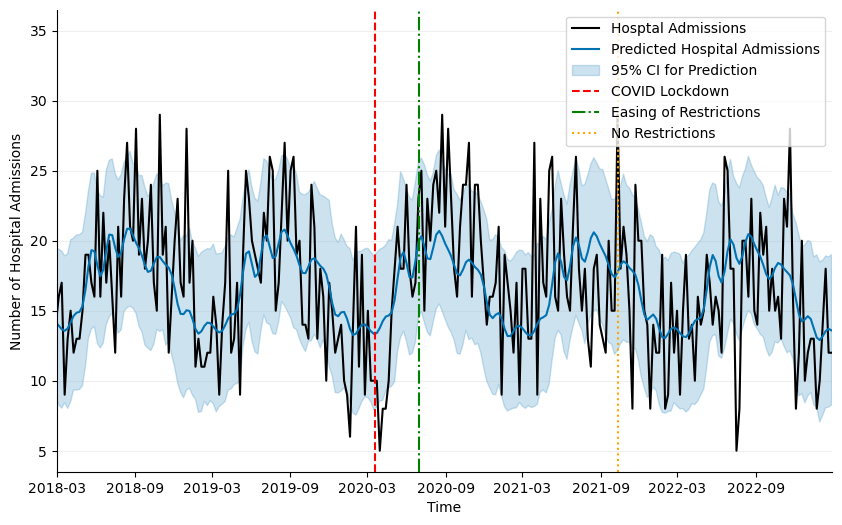

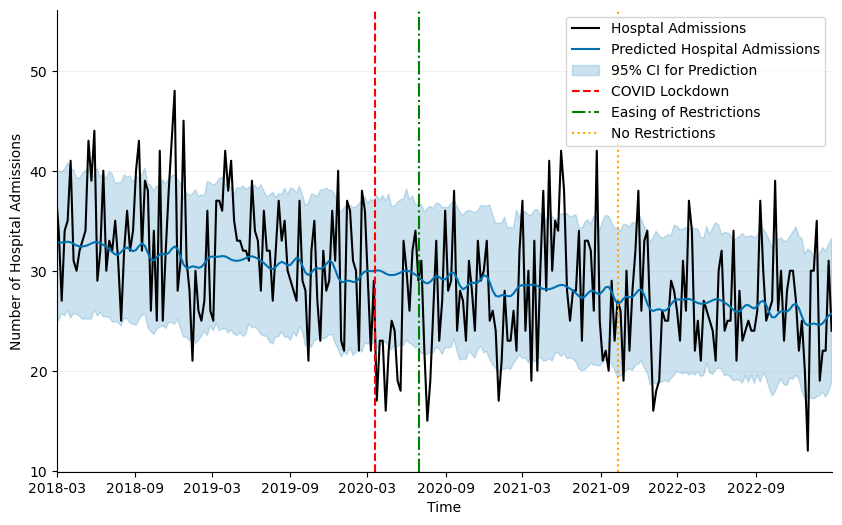

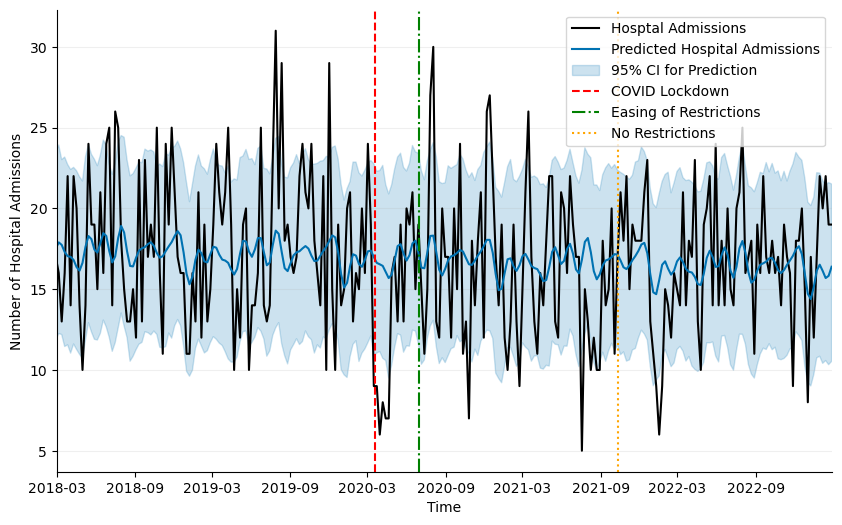

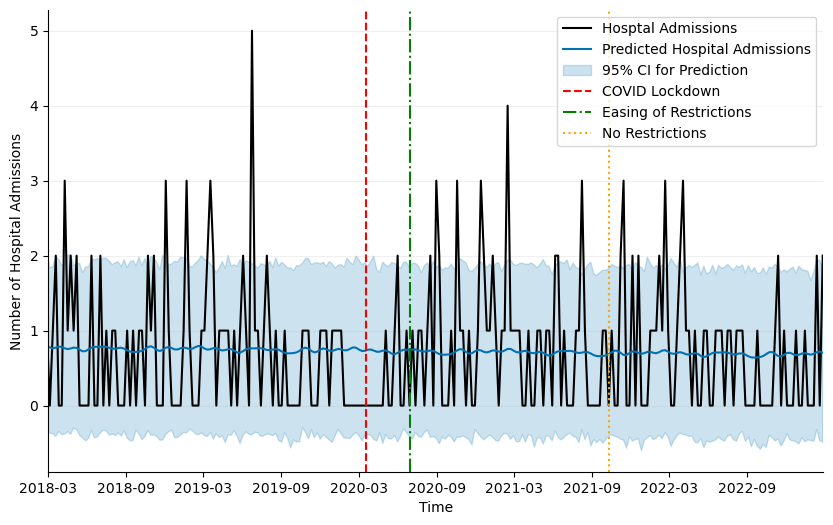

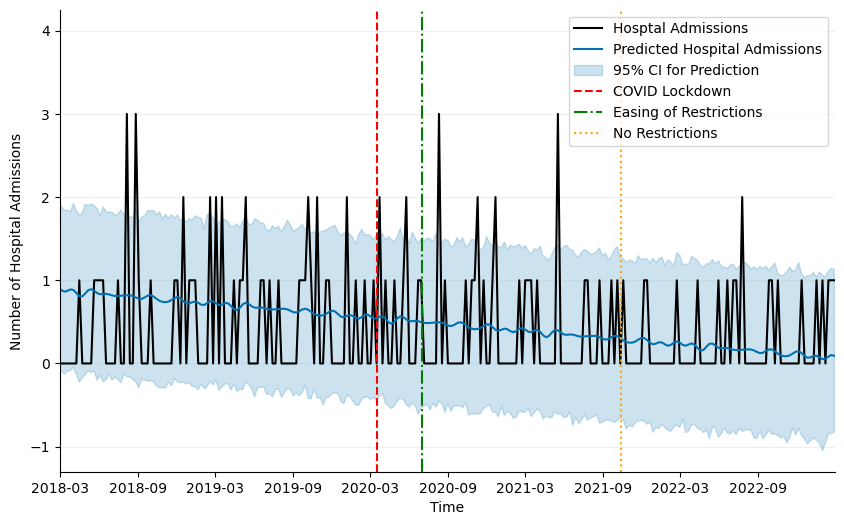

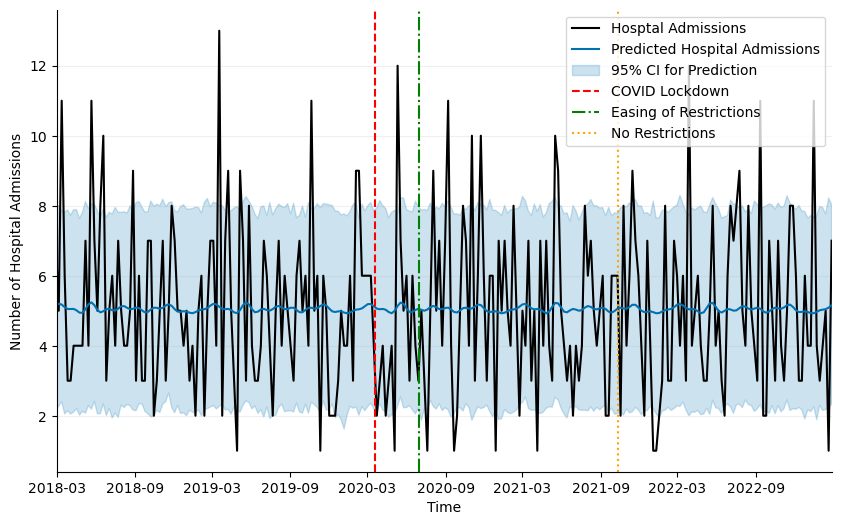

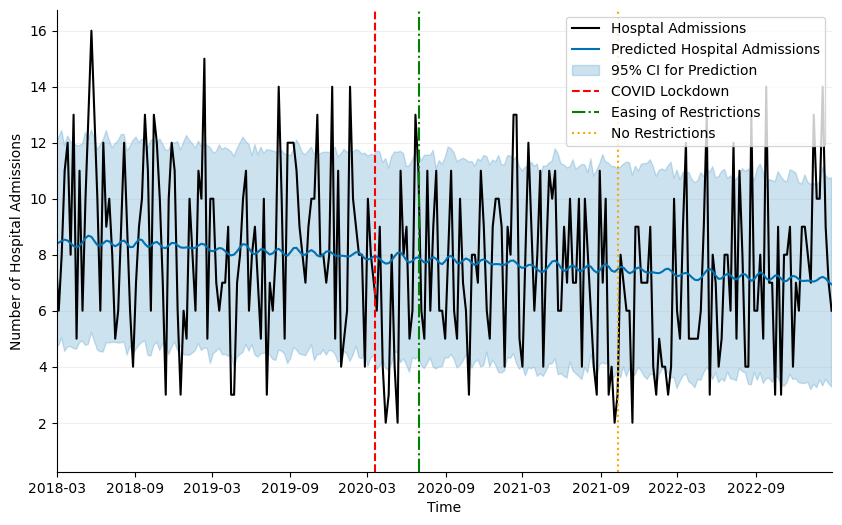

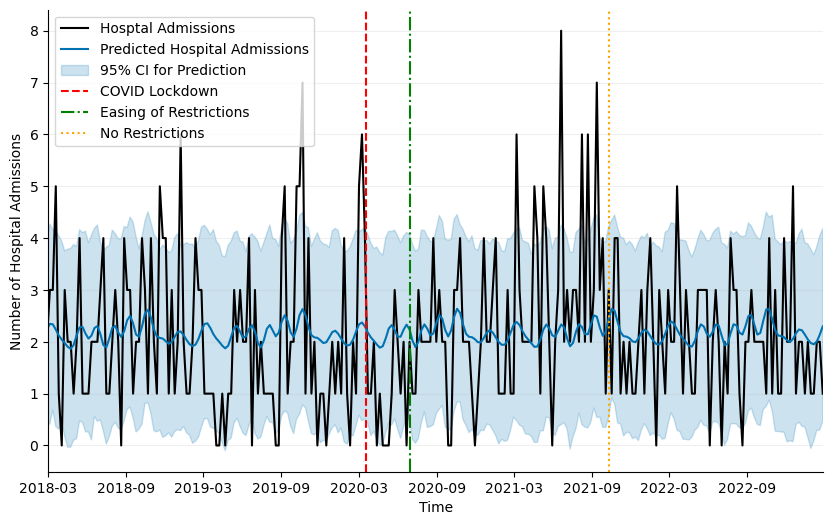

In [102]:
for diag in diagnosis_list:
   
    label = "p_a_weekly_"+diag.replace(" ", "_")
    
    with open('model/' + label + '.json', 'r') as fin:
        m = model_from_json(fin.read())
    
    fig,ax = plot_graph(m)
    plt.savefig("figures/" + label + ".png",bbox_inches = "tight")

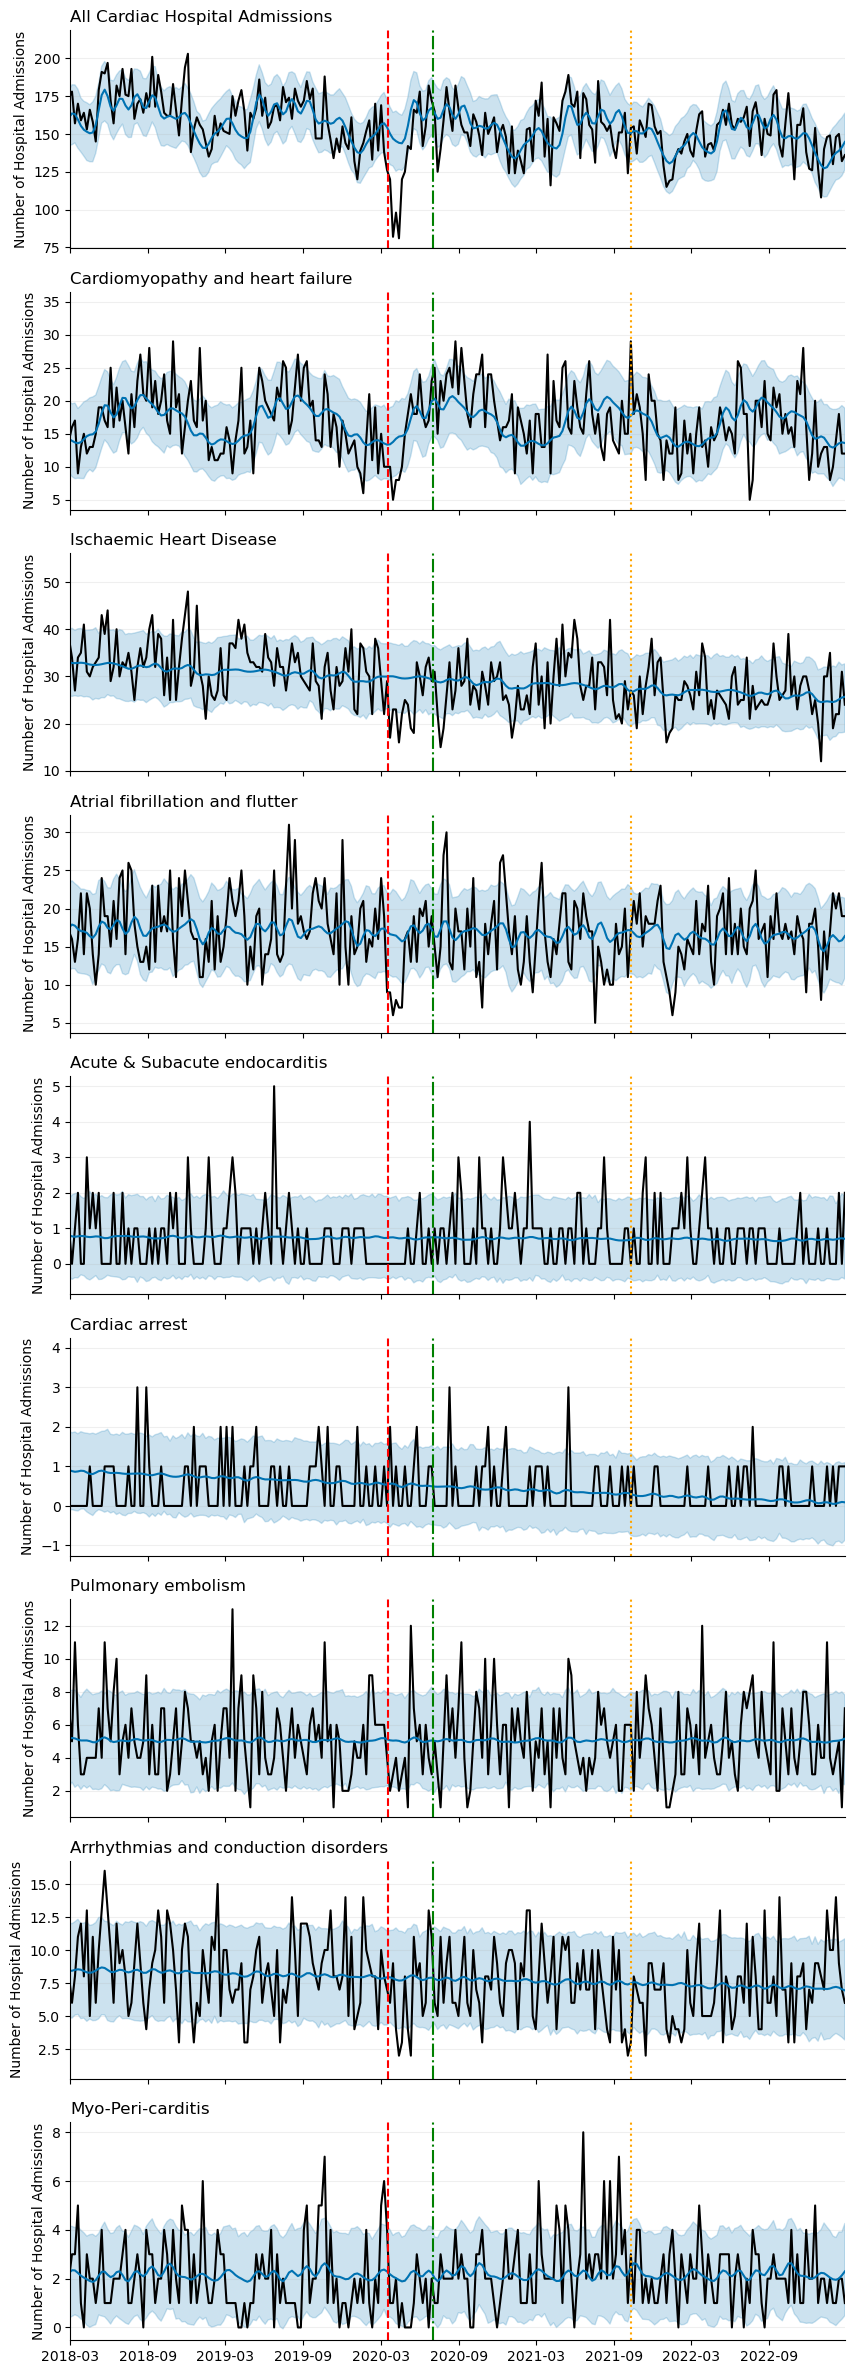

In [21]:
#fig = plt.figure(facecolor='w',figsize=(10,6))
#ax = fig.add_subplot(111)
with open('model/p_a_weekly.json', 'r') as fin:
    m = model_from_json(fin.read())  # Load model
fig,ax = plt.subplots(9, sharex=True,figsize=(10,30))

fig,ax0 = plot_graph(m,ax=ax[0],fig=fig,legend=False)
ax0.set_title('All Cardiac Hospital Admissions', loc='left')

i = 1
for diag in diagnosis_list:
   
    label = "p_a_weekly_"+diag.replace(" ", "_")
    
    with open('model/' + label + '.json', 'r') as fin:
        m = model_from_json(fin.read())
    
    fig,ax_k = plot_graph(m,ax=ax[i],fig=fig,legend=False)
    ax_k.set_title(diag, loc='left')
    
    i+=1
plt.savefig("figures/all_diagnosis.png",bbox_inches = "tight")

### Primary only

In [104]:
primary_df =  df.query("PRIMARY_DIAGNOSIS == PRIMARY_DIAGNOSIS")


primary_temp_result, model = train_model(primary_df,
                                 "primary_weekly",
                                 period_dict,
                                 end_date = end_date,
                                 start_date = start_date,
                                mode = "weekly",
                                 param_grid = param_grid,)
    
with open('model/p_weekly.json', 'w') as fout:
    fout.write(model_to_json(model)) 

16:02:26 - cmdstanpy - INFO - Chain [1] start processing
16:02:26 - cmdstanpy - INFO - Chain [1] done processing
16:02:26 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
16:02:26 - cmdstanpy - INFO - Chain [1] start processing
16:02:26 - cmdstanpy - INFO - Chain [1] done processing
16:02:34 - cmdstanpy - INFO - Chain [1] start processing
16:02:34 - cmdstanpy - INFO - Chain [1] done processing
16:02:34 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
16:02:34 - cmdstanpy - INFO - Chain [1] start processing
16:02:34 - cmdstanpy - INFO - Chain [1] done processing
16:02:58 - cmdstanpy - INFO - Chain [1] start processing
16:02:58 - cmdstanpy - INFO - Chain [1] done processing
16:02:58 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abn

In [105]:
primary_temp_result

yhat  yhat_upper  yhat_lower     f_test  f_test_p  kruskal_test  \
0  16.097747   27.978703   -0.290458  13.414459  0.000002     12.248025   

   kruskal_test_p  alexandergovern_test  alexandergovern_test_p  \
0         0.00219              9.086292                 0.01064   

             name  changepoint_prior_scale  seasonality_prior_scale  \
0  primary_weekly                     0.01                     0.02   

   n_changepoints  daily_seasonality  
0               0              False

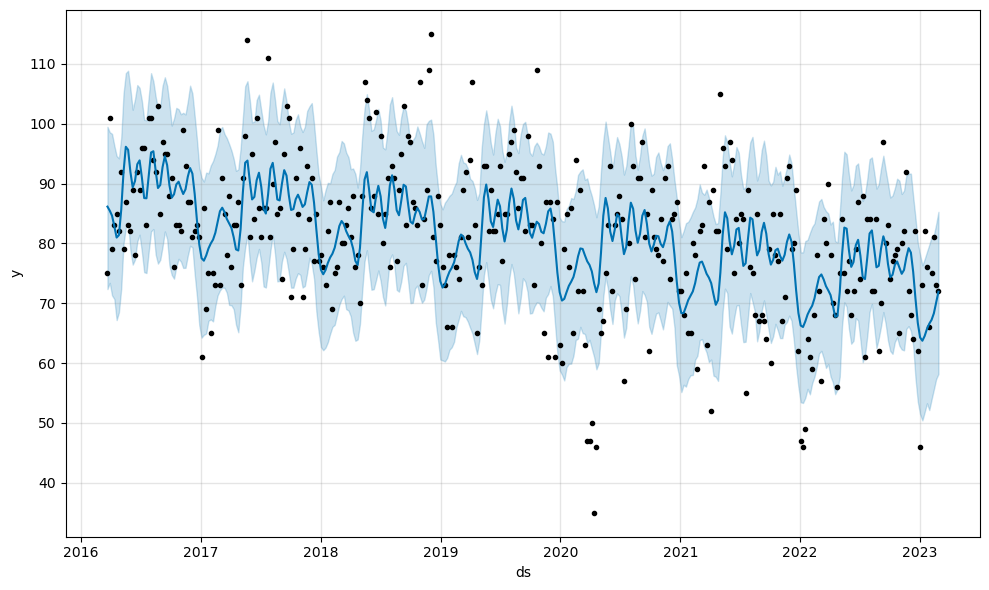

In [106]:
forecast = model.predict()
fig = model.plot(forecast)

In [117]:
for diag in diagnosis_list:
    print("running model for ", diag)
    diag_df =  df.query("PRIMARY_DIAGNOSIS == @diag")
    
    label = "p_weekly_"+diag.replace(" ", "_")
    
    temp_result_p, model_p =  train_model(diag_df,
                                 label,
                                 period_dict,
                                param_grid = param_grid,
                                 end_date = end_date,
                                 start_date = start_date,
                                mode = "weekly")
    primary_temp_result = pd.concat([primary_temp_result,temp_result_p],ignore_index=True)
    
    
    with open('model/' + label + '.json', 'w') as fout:
        fout.write(model_to_json(model)) 

16:16:30 - cmdstanpy - INFO - Chain [1] start processing


running model for  Cardiomyopathy and heart failure


16:16:30 - cmdstanpy - INFO - Chain [1] done processing
16:16:30 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
16:16:30 - cmdstanpy - INFO - Chain [1] start processing
16:16:30 - cmdstanpy - INFO - Chain [1] done processing
16:16:52 - cmdstanpy - INFO - Chain [1] start processing
16:16:52 - cmdstanpy - INFO - Chain [1] done processing
16:16:52 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
16:16:52 - cmdstanpy - INFO - Chain [1] start processing
16:16:59 - cmdstanpy - INFO - Chain [1] done processing
16:17:07 - cmdstanpy - INFO - Chain [1] start processing
16:17:07 - cmdstanpy - INFO - Chain [1] done processing
16:17:07 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
16:17:07 - cmdstanpy - I

running model for  Ischaemic Heart Disease


16:19:56 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
16:19:56 - cmdstanpy - INFO - Chain [1] start processing
16:19:56 - cmdstanpy - INFO - Chain [1] done processing
16:20:03 - cmdstanpy - INFO - Chain [1] start processing
16:20:03 - cmdstanpy - INFO - Chain [1] done processing
16:20:03 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
16:20:03 - cmdstanpy - INFO - Chain [1] start processing
16:20:04 - cmdstanpy - INFO - Chain [1] done processing
16:20:15 - cmdstanpy - INFO - Chain [1] start processing
16:20:15 - cmdstanpy - INFO - Chain [1] done processing
16:20:15 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
16:20:15 - cmdstanpy - INFO - Chain [1] start processing
16:20:17 - cmdstanpy - 

running model for  Atrial fibrillation and flutter


16:22:10 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
16:22:10 - cmdstanpy - INFO - Chain [1] start processing
16:22:10 - cmdstanpy - INFO - Chain [1] done processing
16:22:26 - cmdstanpy - INFO - Chain [1] start processing
16:22:26 - cmdstanpy - INFO - Chain [1] done processing
16:22:26 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
16:22:26 - cmdstanpy - INFO - Chain [1] start processing
16:22:26 - cmdstanpy - INFO - Chain [1] done processing
16:22:33 - cmdstanpy - INFO - Chain [1] start processing
16:22:34 - cmdstanpy - INFO - Chain [1] done processing
16:22:34 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
16:22:34 - cmdstanpy - INFO - Chain [1] start processing
16:22:34 - cmdstanpy - 

running model for  Acute & Subacute endocarditis


16:25:04 - cmdstanpy - INFO - Chain [1] done processing
16:25:31 - cmdstanpy - INFO - Chain [1] start processing
16:25:31 - cmdstanpy - INFO - Chain [1] done processing
16:25:31 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
16:25:31 - cmdstanpy - INFO - Chain [1] start processing
16:25:31 - cmdstanpy - INFO - Chain [1] done processing
16:26:01 - cmdstanpy - INFO - Chain [1] start processing
16:26:01 - cmdstanpy - INFO - Chain [1] done processing
16:26:01 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
16:26:01 - cmdstanpy - INFO - Chain [1] start processing
16:26:01 - cmdstanpy - INFO - Chain [1] done processing
16:26:24 - cmdstanpy - INFO - Chain [1] start processing
16:26:24 - cmdstanpy - INFO - Chain [1] done processing
16:26:24 - cmdstanpy - ERROR - Chain [1] error: error during proces

running model for  Cardiac arrest


16:29:45 - cmdstanpy - INFO - Chain [1] start processing
16:29:45 - cmdstanpy - INFO - Chain [1] done processing
16:29:55 - cmdstanpy - INFO - Chain [1] start processing
16:29:55 - cmdstanpy - INFO - Chain [1] done processing
16:29:55 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
16:29:55 - cmdstanpy - INFO - Chain [1] start processing
16:29:55 - cmdstanpy - INFO - Chain [1] done processing
16:30:03 - cmdstanpy - INFO - Chain [1] start processing
16:30:03 - cmdstanpy - INFO - Chain [1] done processing
16:30:03 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
16:30:03 - cmdstanpy - INFO - Chain [1] start processing
16:30:03 - cmdstanpy - INFO - Chain [1] done processing
16:30:11 - cmdstanpy - INFO - Chain [1] start processing
16:30:11 - cmdstanpy - INFO - Chain [1] done processing
16:30:11 -

running model for  Pulmonary embolism 


16:31:45 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
16:31:45 - cmdstanpy - INFO - Chain [1] start processing
16:31:46 - cmdstanpy - INFO - Chain [1] done processing
16:32:06 - cmdstanpy - INFO - Chain [1] start processing
16:32:07 - cmdstanpy - INFO - Chain [1] done processing
16:32:07 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
16:32:07 - cmdstanpy - INFO - Chain [1] start processing
16:32:07 - cmdstanpy - INFO - Chain [1] done processing
16:32:28 - cmdstanpy - INFO - Chain [1] start processing
16:32:28 - cmdstanpy - INFO - Chain [1] done processing
16:32:28 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
16:32:28 - cmdstanpy - INFO - Chain [1] start processing
16:32:29 - cmdstanpy - 

running model for  Arrhythmias and conduction disorders


16:35:27 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
16:35:27 - cmdstanpy - INFO - Chain [1] start processing
16:35:27 - cmdstanpy - INFO - Chain [1] done processing
16:35:43 - cmdstanpy - INFO - Chain [1] start processing
16:35:43 - cmdstanpy - INFO - Chain [1] done processing
16:35:43 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
16:35:43 - cmdstanpy - INFO - Chain [1] start processing
16:35:43 - cmdstanpy - INFO - Chain [1] done processing
16:35:59 - cmdstanpy - INFO - Chain [1] start processing
16:35:59 - cmdstanpy - INFO - Chain [1] done processing
16:35:59 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
16:35:59 - cmdstanpy - INFO - Chain [1] start processing
16:35:59 - cmdstanpy - 

running model for  Myo-Peri-carditis


16:38:19 - cmdstanpy - INFO - Chain [1] start processing
16:38:19 - cmdstanpy - INFO - Chain [1] done processing
16:38:19 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
16:38:19 - cmdstanpy - INFO - Chain [1] start processing
16:38:19 - cmdstanpy - INFO - Chain [1] done processing
16:39:05 - cmdstanpy - INFO - Chain [1] start processing
16:39:05 - cmdstanpy - INFO - Chain [1] done processing
16:39:05 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
16:39:05 - cmdstanpy - INFO - Chain [1] start processing
16:39:05 - cmdstanpy - INFO - Chain [1] done processing
16:39:52 - cmdstanpy - INFO - Chain [1] start processing
16:39:52 - cmdstanpy - INFO - Chain [1] done processing
16:39:52 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abn

In [119]:
primary_temp_result.to_csv("primary_weekly_results.csv",index=False)

In [ ]:
with open('serialized_model.json', 'r') as fin:
    m = model_from_json(fin.read())  # Load model